In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


data = pd.read_csv('train.csv')
trainData = pd.read_csv('fashion-mnist_train.csv')
testData = pd.read_csv('fashion-mnist_test.csv')

In [2]:
# Importing the training and testing data from the dataset
trainData = np.array(trainData)
testData = np.array(testData)

# Getting the dimensions for the two sets of data
m, n = trainData.shape
x, y = testData.shape
#np.random.shuffle(data) # shuffle before splitting into dev and training sets

# Transposing and setting up the data for use
data_dev = testData.T
Y_dev = data_dev[:1]
X_dev = data_dev[1:y]
X_dev = X_dev / 255.
data_train = trainData.T
Y_train = data_train[:1]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape


In [3]:
# Preview of what the data postprocessing looks like
Y_train[:5]


array([[2, 9, 6, ..., 8, 8, 7]], dtype=int64)

In [4]:
# Initilising function to set up the layer sizes
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

# Relu function, which replaces any negative values with zero and leaves the positive values unchanged
def ReLU(Z):
    return np.maximum(Z, 0)

# Softmax function for activation
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
# The forward pass function, using relu softmax and dot procucts
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Function for derivatative of relu
def ReLU_deriv(Z):
    return Z > 0


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Function for  backwards pass 
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

# Updating of parameters before each pass
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

#Updating of parameters with ADAM.
def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    eta=0.01
    beta1=0.9
    beta2=0.999
    epsilon=1e-8
    t= 1
    m_dw1, v_dw1 = 0, 0
    m_db1, v_db1 = 0, 0
    m_dw2, v_dw2 = 0, 0
    m_db2, v_db2 = 0, 0
    
    # weights
    m_dw1 = beta1*m_dw1 + (1-beta1)*dW1
    m_dw2 = beta1*m_dw2 + (1-beta1)*dW2
    # biases
    m_db1 = beta1*m_db1 + (1-beta1)*db1
    m_db2 = beta1*m_db2 + (1-beta1)*db2

    # weights
    v_dw1 = beta2*v_dw1 + (1-beta2)*(dW1**2)
    v_dw2 = beta2*v_dw2 + (1-beta2)*(dW2**2)
    # biases
    v_db1 = beta2*v_db1 + (1-beta2)*(db1*db1)
    v_db2 = beta2*v_db2 + (1-beta2)*(db2*db2)

    # bias correction
    m_dw1_corr = m_dw1/(1-beta1**t)
    m_db1_corr = m_db1/(1-beta1**t)
    v_dw1_corr = v_dw1/(1-beta2**t)
    v_db1_corr = v_db1/(1-beta2**t)       
    m_dw2_corr = m_dw2/(1-beta1**t)
    m_db2_corr = m_db2/(1-beta1**t)
    v_dw2_corr = v_dw2/(1-beta2**t)
    v_db2_corr = v_db2/(1-beta2**t)

    ## update weights and biases
    W1 = W1 - eta*(m_dw1_corr/(np.sqrt(v_dw1_corr)+epsilon))
    b1 = b1 - eta*(m_db1_corr/(np.sqrt(v_db1_corr)+epsilon))
        
    W2 = W2 - eta*(m_dw2_corr/(np.sqrt(v_dw2_corr)+epsilon))
    b2 = b2 - eta*(m_db2_corr/(np.sqrt(v_db2_corr)+epsilon))
    return W1, b1, W2, b2 

In [13]:
def get_predictions(A2):
    return np.argmax(A2, 0)

# Returns the accuracy of the model based on the current predictions by comparing them with the expected results.
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

#The main function, iterating through the layers, gaining accuracy.
def gradient_descent(X, Y, alpha, iterations , loss , acuraccy, testAccuracy , W1, b1, W2, b2):  
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        ## The line above is replaced with the line below to use ADAM while running the model
        #W1, b1, W2, b2 = update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # To help visualize the data and to store accuracies this is done every specified number of 
        # iterations. With the value of mod i can be alterted to do it more or less often
        if i % 2 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            #print(predictions)
            acuraccy.append(get_accuracy(predictions, Y))
            print(get_accuracy(predictions, Y))
            #print(get_loss(Y, predictions))
            dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
            testAccuracy.append(get_accuracy(dev_predictions, Y_dev))
            
    return W1, b1, W2, b2

In [14]:
# Using the trained gradient this function predicts what the image labels would be and returns them as a list.
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [15]:
#Empty lists being initialiszed to store accuracies and loss over the iterations. 
accuracy = []
testAccuracy = []
loss = []

# Function definition to train the model.
def train(epoch ,iterations ,learningRate ):
    W1, b1, W2, b2 = init_params()
    for j in range(epoch):
        W1, b1, W2, b2 = gradient_descent(X_train, Y_train, learningRate, iterations , loss , accuracy , testAccuracy , W1, b1, W2, b2 )
        
# Epoch, learning rate and iteration values to be set by the user to evaluate the model with different conditions 
epoch = 2
iterations = 400
learningRate = 0.01
# Training the model using the specified parameters
train(epoch , iterations , learningRate)


Iteration:  0
0.07336666666666666
Iteration:  2
0.1316
Iteration:  4
0.14123333333333332
Iteration:  6
0.18536666666666668
Iteration:  8
0.21708333333333332
Iteration:  10
0.2422
Iteration:  12
0.2634
Iteration:  14
0.2842166666666667
Iteration:  16
0.30916666666666665
Iteration:  18
0.3384333333333333
Iteration:  20
0.37015
Iteration:  22
0.40158333333333335
Iteration:  24
0.4368666666666667
Iteration:  26
0.4698
Iteration:  28
0.49706666666666666
Iteration:  30
0.5171166666666667
Iteration:  32
0.5332333333333333
Iteration:  34
0.5464833333333333
Iteration:  36
0.55745
Iteration:  38
0.5665166666666667
Iteration:  40
0.57465
Iteration:  42
0.5812166666666667
Iteration:  44
0.5874666666666667
Iteration:  46
0.5931166666666666
Iteration:  48
0.5985
Iteration:  50
0.60295
Iteration:  52
0.6070833333333333
Iteration:  54
0.6115333333333334
Iteration:  56
0.6152833333333333
Iteration:  58
0.6185666666666667
Iteration:  60
0.6218166666666667
Iteration:  62
0.6252
Iteration:  64
0.628116666

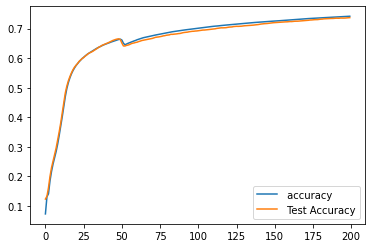

In [16]:
# Plotting the accuracies of the model on the test and training datasets for comparison.
plt.plot(accuracy, label= " accuracy")
plt.plot(testAccuracy, label= " Test Accuracy")
plt.legend()
# Accuracy of the model with itterations on the x axis and accuracy on the y axis

In [19]:
# Function to test the model predictions using an index which indexes the image in the dataset.
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    


Prediction:  [7]
Label:  [7]


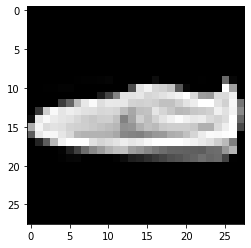

Prediction:  [0]
Label:  [0]


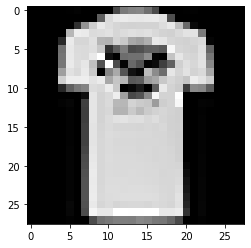

Prediction:  [3]
Label:  [3]


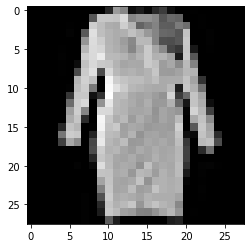

Prediction:  [7]
Label:  [7]


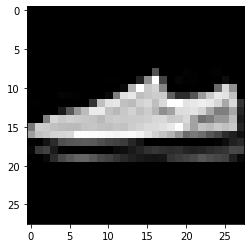

In [20]:
# Random images from the dataset being testes, the values can be changed to any within the index of the dataset.
Y_train = Y_train.T
test_prediction(47, W1, b1, W2, b2)
test_prediction(441, W1, b1, W2, b2)
test_prediction(300, W1, b1, W2, b2)
test_prediction(94, W1, b1, W2, b2)